# Prueba del paquete GeoPandas para hacer mapas

* Se usarán datos públicos del vizualizador **IDEcanarias**

In [88]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar

## Descarga de los datos

* Necesario el archivo en la carpeta ```metadata```: ```metadatos_medio_ambiente.csv``` 

### ¡Se creó otro script en PowerShell que funciona mejor!

* Este sería el script: [idecanarias_webscraping.ps1](idecanarias_webscraping.ps1).
* Aún así dejo este por si algún día tengo que hacer en esto en Python

```
#################################
##    Descarga de los datos    ##
#################################

directorio_destino = '..\\data'

metadata = pd.read_csv('..\\metadata\\metadatos_medio_ambiente.csv')
directorio_destino = '..\\data'

for url in list(metadata["url"]):
    try:
        # Obtener el nombre del archivo de la URL
        nombre_archivo = os.path.join(directorio_destino, os.path.basename(url))

        # Descargar el archivo
        response = requests.get(url)
        with open(nombre_archivo, 'wb') as file:
            file.write(response.content)

        print(f"Archivo descargado: {nombre_archivo}")

        # Descomprimir el archivo
        with zipfile.ZipFile(nombre_archivo, 'r') as zip_ref:
            zip_ref.extractall(directorio_destino)
            print(f"Archivos descomprimidos en: {directorio_destino}")

    except Exception as e:
        print(f"Error al descargar {url}: {e}")
```

## Leer los datos SHP y GeoPackage

* Se usará la función ```gpd.read_file()```

In [3]:
eennpp = gpd.read_file("..\\data\\eennpp.shp")
islas_canarias = gpd.read_file("..\\data\\islas_generalizadas.shp") 
especies_protegidas = gpd.read_file("..\\data\\especies-protegidas.gpkg")  
mapa_geotecnico_grupos = gpd.read_file("..\\data\\gobcan_mapa-geotecnico_grupos-terreno-cte.shp")
mapa_geotecnico_ug = gpd.read_file("..\\data\\gobcan_mapa-geotecnico_unidades-geologicas.shp")
municipios = gpd.read_file("..\\data\\municipios.shp")

In [7]:
eennpp.head()

,codigo,categoria,nombre,geometry
0,H-6,Paisaje Protegido,Ventejís,"POLYGON ((207380.300 3077264.524, 207361.430 3..."
1,H-7,Paisaje Protegido,Timijiraque,"POLYGON ((212318.690 3076408.720, 212322.130 3..."
2,H-3,Reserva Natural Especial,Tibataje,"POLYGON ((205028.180 3074960.459, 205020.849 3..."
3,H-2,Reserva Natural Integral,Roques de Salmor,"MULTIPOLYGON (((205086.150 3081134.320, 205088..."
4,H-5,Monumento Natural,Las Playas,"MULTIPOLYGON (((209998.290 3070692.910, 209998..."


In [8]:
islas_canarias.head()

,nombre,geometry
0,FUERTEVENTURA,"POLYGON ((614400.417 3179644.575, 614046.617 3..."
1,FUERTEVENTURA,"POLYGON ((589085.283 3152305.979, 589312.973 3..."
2,EL HIERRO,"POLYGON ((205260.539 3081076.767, 205665.090 3..."
3,TENERIFE,"POLYGON ((338109.671 3142160.390, 338626.550 3..."
4,LANZAROTE,"POLYGON ((645049.534 3254822.134, 645270.045 3..."


<Axes: >

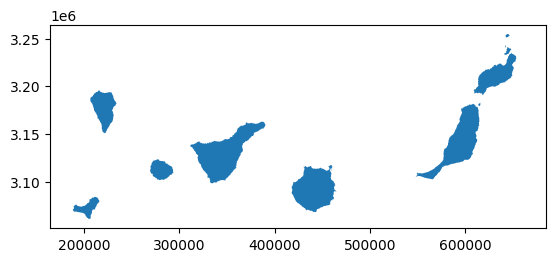

In [9]:
islas_canarias.plot()


In [10]:
especies_protegidas.head()

,isla,riqueza,fila,columna,geometry
0,MA,1,1108,746,"POLYGON ((187500.000 3056000.000, 187500.000 3..."
1,EH,3,1081,747,"POLYGON ((188000.000 3069500.000, 188000.000 3..."
2,EH,1,1080,747,"POLYGON ((188000.000 3070000.000, 188000.000 3..."
3,EH,1,1079,747,"POLYGON ((188000.000 3070500.000, 188000.000 3..."
4,EH,1,1078,747,"POLYGON ((188000.000 3071000.000, 188000.000 3..."


## Preprocesamiento de los datos

In [4]:
filtro_generalizado = islas_canarias["nombre"] == "GRAN CANARIA"
gran_canaria_isla = islas_canarias[filtro_generalizado]
gran_canaria_isla.head()

,nombre,geometry
10,GRAN CANARIA,"POLYGON ((430739.466 3110342.654, 430337.649 3..."


In [5]:
filtro_muni_gc = municipios["isla"] == "GRAN CANARIA"
gc_municipios = municipios[filtro_muni_gc]
gc_municipios.head()


,id,codmun,municipio,isla,geometry
36,37,35025,TEJEDA,GRAN CANARIA,"POLYGON ((441008.941 3098627.016, 441009.141 3..."
37,38,35005,ARTENARA,GRAN CANARIA,"MULTIPOLYGON (((424194.425 3101233.193, 424192..."
38,39,35032,VALLESECO,GRAN CANARIA,"POLYGON ((445351.120 3105995.000, 445333.691 3..."
39,40,35013,MOYA,GRAN CANARIA,"MULTIPOLYGON (((443980.635 3113514.216, 443979..."
40,41,35009,GÁLDAR,GRAN CANARIA,"MULTIPOLYGON (((430845.114 3113210.078, 430846..."


In [6]:
# filtro_tafira = eennpp["nombre"] == "Tafira"
filtro_tafira = eennpp["nombre"].isin(["Tafira", "Bandama"]) 
eennpp_tafira = eennpp[filtro_tafira]
eennpp_tafira.head()

,codigo,categoria,nombre,geometry
28,C-24,Paisaje Protegido,Tafira,"POLYGON ((455266.194 3104353.840, 455267.026 3..."
36,C-14,Monumento Natural,Bandama,"POLYGON ((454972.768 3102114.880, 454980.146 3..."


In [7]:
especies_protegiodas_tafira = gpd.overlay(especies_protegidas, 
                                          eennpp_tafira, 
                                          how="intersection")
especies_protegiodas_tafira_muni = gpd.overlay(especies_protegiodas_tafira, 
                                               eennpp_tafira, 
                                               how="intersection") 
especies_protegiodas_tafira_muni.head()

,isla,riqueza,fila,columna,codigo_1,categoria_1,nombre_1,codigo_2,categoria_2,nombre_2,geometry
0,GC,6,1021,1275,C-24,Paisaje Protegido,Tafira,C-24,Paisaje Protegido,Tafira,"POLYGON ((452500.000 3099555.057, 452494.512 3..."
1,GC,1,1020,1275,C-24,Paisaje Protegido,Tafira,C-24,Paisaje Protegido,Tafira,"MULTIPOLYGON (((452026.300 3100000.000, 452026..."
2,GC,9,1021,1276,C-24,Paisaje Protegido,Tafira,C-24,Paisaje Protegido,Tafira,"POLYGON ((453000.000 3100000.000, 453000.000 3..."
3,GC,2,1017,1276,C-24,Paisaje Protegido,Tafira,C-24,Paisaje Protegido,Tafira,"POLYGON ((452512.896 3101675.872, 452525.906 3..."
4,GC,2,1016,1277,C-24,Paisaje Protegido,Tafira,C-24,Paisaje Protegido,Tafira,"MULTIPOLYGON (((453237.692 3102000.000, 453238..."


In [8]:
filtro = eennpp["codigo"].str.startswith("C")
eennp_gran_canaria = eennpp[filtro]
eennp_gran_canaria.head()

,codigo,categoria,nombre,geometry
20,C-32,Sitio de Interés Científico,Juncalillo del Sur,"POLYGON ((453679.696 3074570.097, 453669.984 3..."
21,C-31,Sitio de Interés Científico,Roque de Gando,"POLYGON ((464665.536 3090497.440, 464658.994 3..."
22,C-30,Sitio de Interés Científico,Tufia,"POLYGON ((462277.610 3093302.880, 462281.280 3..."
23,C-29,Sitio de Interés Científico,Jinámar,"POLYGON ((460256.224 3101297.088, 460260.274 3..."
24,C-28,Paisaje Protegido,Montaña de Agüimes,"POLYGON ((458220.295 3087279.345, 458220.210 3..."


## Visualización de los resulatdos

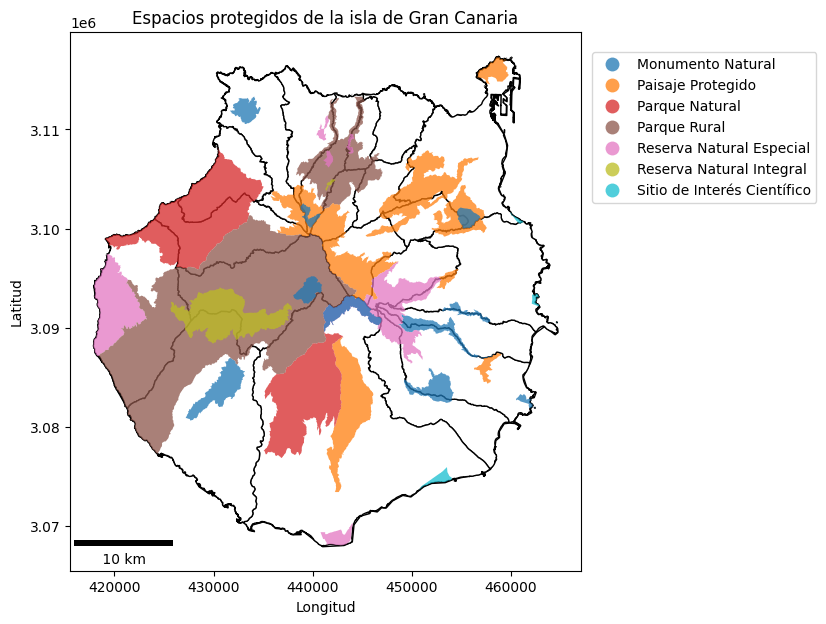

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

gran_canaria_isla = gran_canaria_isla.to_crs("EPSG:32628")
gc_municipios = gc_municipios.to_crs("EPSG:32628")
eennp_gran_canaria = eennp_gran_canaria.to_crs("EPSG:32628")

gran_canaria_isla.plot(ax=ax, facecolor="white", 
                       edgecolor="black")
gc_municipios.plot(ax=ax, facecolor="white", 
                       edgecolor="black")
plot = eennp_gran_canaria.plot(column='categoria', 
                                legend=True, 
                                ax=ax,  
                                alpha = .75)


# Ajustar la escala y la ubicación de la barra de escala
# Personalizar la apariencia de la barra de escala
scale_bar = ScaleBar(1, location='lower right')
ax.add_artist(ScaleBar(
    dx=1,
    units="km",
    dimension="si-length",
    scale_formatter=lambda value, unit: f' {value * 1} km ',
    location='lower left'
))

# Configurar etiquetas de ejes
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")
ax.yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
# Set axis labels and title
ax.set_title("Espacios protegidos de la isla de Gran Canaria")
leg = plot.get_legend()
leg.set_bbox_to_anchor((1.475, 0.975))
#ax.set_axis_off()


In [93]:
## Descargar Las capas
gran_canaria_isla.to_file("..\\data\\gran_canaria_isla.shp")
gc_municipios.to_file("..\\data\\gc_municipios.shp")
eennp_gran_canaria.to_file("..\\data\\eennp_gran_canaria.shp")

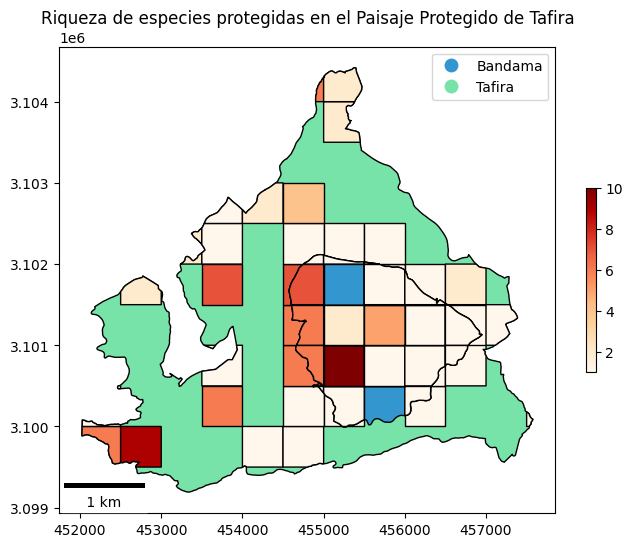

In [75]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

eennpp_tafira.plot(ax=ax, 
                   column = "nombre", 
                   edgecolor= "black",
                   cmap=ListedColormap(["#3496cf", "#78e3a8"]),
                   legend=True)

plot = especies_protegiodas_tafira_muni.plot(column="riqueza", 
                                             ax=ax, 
                                             legend=True, 
                                             legend_kwds={'shrink': 0.3}, 
                                             cmap="OrRd",
                                             edgecolor="black")
ax.add_artist(ScaleBar(
    dx=1,
    units="km",
    scale_formatter=lambda value, unit: f' {value * 1} km ',
    location='lower left'
))

ax.set_title("Riqueza de especies protegidas en el Paisaje Protegido de Tafira")
leg = plot.get_legend()
#ax.set_axis_off()


In [99]:
## Descargar Las capas
eennpp_tafira.to_file("..\\data\\eennpp_tafira.shp")
especies_protegiodas_tafira.to_file("..\\data\\especies_protegiodas_tafira.shp")

C:\Users\jcge9\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


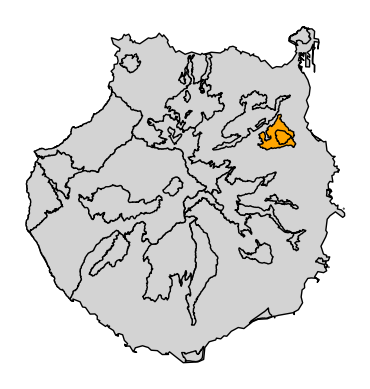

In [57]:
## Ejercicio de colorear tafira como en la portada del Documento Noprmativo

# Otra forma
# import numpy as np
# eennp_gran_canaria["is_tafira"] = np.select(
#     [eennp_gran_canaria["nombre"] == "Tafira",
#      eennp_gran_canaria["nombre"] == "Bandama"],
#     ["Tafira", "Bandama"],
#     default="Resto"
# )

eennp_gran_canaria["is_tafira"] = eennp_gran_canaria["nombre"].isin(["Tafira", "Bandama"])
fig, ax = plt.subplots(1,1)
gran_canaria_isla.plot(ax=ax, 
                       edgecolor="black", 
                       facecolor="lightgray")
eennp_gran_canaria.plot(ax=ax, 
                        edgecolor="black", 
                        column="is_tafira", 
                        cmap=ListedColormap(["lightgray", "orange"]))
ax.set_axis_off()